# Random Forest Classification of Depression and Gender by Vocal Characteristics
In this project, we will train a Random Forest Classifier to determine whether a participant has depression based on speech data from a clinical interview. The dataset contains 107 participants, 63 of which are male and 44 of which are female. Of these participants, 30 have depression (17 female, 14 male). By varying the weights and features included in the model training, we will demonstrate how differing analysis techniques can have significant impact on the model's classification performance. 

In [3]:
# **** MATH OPERATIONS ****
import numpy as np
import os

# **** DATA MANIPULATION ****
import pandas as pd


In [50]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def load_features(path, labels_df):
    dataframes = []
    
    for file in os.listdir(path):
        if file.split('.')[1] != 'csv':
            continue
        df = pd.read_csv(os.path.join(path, file), header=None)
        participant_id = int(file.split("_")[1].split(".")[0]) # Get ID from file name
        df["Participant_ID"] = participant_id
        dataframes.append(df)
        
    # Combine into a single dataframe
    data_df = pd.concat(dataframes)
    return data_df.merge(labels_df, on="Participant_ID")

def analyze_results(test_df, display_results=True):
    # Group by participant and average predictions 
    participant_predictions_depression = test_df.groupby("Participant_ID")["predictions"].mean()

    # Binarize the predictions from 0.5 threshold
    threshold = 0.05
    participant_predictions_depression_binarized = (participant_predictions_depression >= threshold).astype(int)

    # Join aggregated predictions back with the depression labels
    participant_labels_depression = test_df.groupby("Participant_ID")["Depression"].first()

    # Filter data by gender
    male_participants = test_df[test_df["Gender"] == 1]["Participant_ID"].unique()
    female_participants = test_df[test_df["Gender"] == 0]["Participant_ID"].unique()

    # Calculate accuracies for all, male, and female participants
    all_metrics_depression = calculate_accuracy(participant_labels_depression, 
                                                participant_predictions_depression_binarized, "All participants",
                                                display_results=display_results)
    if display_results:
        print("")
    male_metrics = calculate_accuracy(participant_labels_depression.loc[male_participants],
                                       participant_predictions_depression_binarized.loc[male_participants], "Male participants",
                                       display_results=display_results)
    if display_results:
        print("")
    female_metrics = calculate_accuracy(participant_labels_depression.loc[female_participants], 
                                        participant_predictions_depression_binarized.loc[female_participants],
                                          "Female participants", display_results=display_results)

    # Calculate EO
    eo = (1 - abs(male_metrics["tpr"] - female_metrics["tpr"]))
    if display_results:
        print(f"Equality of Opportunity (EO): {eo:.2f}")

    return all_metrics_depression, male_metrics, female_metrics, eo

def calculate_accuracy(y_true, y_pred, group, display_results=True):
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    
    # Extract TP, FP, TN, FN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tpr = tp / (tp + fn) # True Positive Rate
    tnr = tn / (tn + fp) # True Negative Rate
    fpr = fp / (fp + tn) # False Positive Rate
    fnr = fn / (fn + tp) # False Negative Rate
    
    # Store metrics
    metrics = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }
    if display_results:
        print(f"Metrics for {group}:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
        print(f"True Positive Rate (TPR): {tpr:.2f}")
        print(f"True Negative Rate (TNR): {tnr:.2f}")
        print(f"False Positive Rate (FPR): {fpr:.2f}")
        print(f"False Negative Rate (FNR): {fnr:.2f}")
    
    return metrics

def train_random_forest(df:pd.DataFrame, classification_feat:str, 
                        depth_list=[10, 20, 40, 60, 80], tree_list=[1, 20, 50, 100, 150, 200]):
    # split into validation and train
    train_df, validation_df = train_test_split(df, test_size=.3)
    train_feat = train_df[classification_feat].values.tolist()
    validation_feat = validation_df[classification_feat].values.tolist()
    train_arr = train_df.drop(columns=[classification_feat]).to_numpy()
    validation_arr = validation_df.drop(columns = [classification_feat]).to_numpy()
    # test multiple max depths and num trees
    best_acc = 0
    best_model, best_num_trees, best_depth = None, None, None
    for max_depth in depth_list:
        for num_trees in tree_list:
            clf = RandomForestClassifier(random_state=42, class_weight='balanced')
            # clf = RandomForestClassifier(num_trees, random_state=42, class_weight='balanced', max_depth=max_depth)
            clf.fit(train_arr, train_feat)
            pred = clf.predict(validation_arr)
            acc = accuracy_score(validation_feat, pred)
            if acc > best_acc:
                best_acc = acc
                best_model = clf
                best_num_trees = num_trees
                best_depth = max_depth
    # return model with best classification accuracy
    return best_model, best_num_trees, best_depth

In [5]:
# Load labels data

labels_df = pd.read_csv("labels.csv")

train_df = load_features("features_train", labels_df)
test_df = load_features("features_test", labels_df)

# Problem (a.i) Depression Classification

In [6]:
from sklearn.preprocessing import StandardScaler

# Handle missing values
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

# Separate features and labels
X_train = train_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_train_depression = train_df["Depression"]
y_train_gender = train_df["Gender"]

X_test = test_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_test_depression = test_df["Depression"]
y_test_gender = test_df["Gender"]

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Depression Classifation
model_depression = RandomForestClassifier(random_state=42, class_weight='balanced')
model_depression.fit(X_train, y_train_depression)



RandomForestClassifier(class_weight='balanced', random_state=42)

In [8]:
# Gender Classification
model_gender = RandomForestClassifier(random_state=42, class_weight='balanced')
model_gender.fit(X_train, y_train_gender)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [9]:


# Evaluate Depression Classification
y_pred_depression = model_depression.predict(X_test)


In [10]:
test_df_depression = test_df.copy()
test_df_depression["predictions"] = y_pred_depression

In [11]:
# Group by participant and average predictions 
participant_predictions_depression = test_df_depression.groupby("Participant_ID")["predictions"].mean()

# Binarize the predictions from 0.5 threshold
threshold = 0.05
participant_predictions_depression_binarized = (participant_predictions_depression >= threshold).astype(int)

# Join aggregated predictions back with the depression labels
participant_labels_depression = test_df_depression.groupby("Participant_ID")["Depression"].first()

In [12]:
# Filter data by gender
male_participants = test_df_depression[test_df_depression["Gender"] == 1]["Participant_ID"].unique()
female_participants = test_df_depression[test_df_depression["Gender"] == 0]["Participant_ID"].unique()

In [13]:
# Calculate accuracies for all, male, and female participants
all_metrics_depression = calculate_accuracy(participant_labels_depression, participant_predictions_depression_binarized, "All participants")
print("")
male_metrics = calculate_accuracy(participant_labels_depression.loc[male_participants], participant_predictions_depression_binarized.loc[male_participants], "Male participants")
print("")
female_metrics = calculate_accuracy(participant_labels_depression.loc[female_participants], participant_predictions_depression_binarized.loc[female_participants], "Female participants")

Metrics for All participants:
Accuracy: 0.55
Balanced Accuracy: 0.58
True Positive Rate (TPR): 0.67
True Negative Rate (TNR): 0.50
False Positive Rate (FPR): 0.50
False Negative Rate (FNR): 0.33

Metrics for Male participants:
Accuracy: 0.58
Balanced Accuracy: 0.77
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.55
False Positive Rate (FPR): 0.45
False Negative Rate (FNR): 0.00

Metrics for Female participants:
Accuracy: 0.50
Balanced Accuracy: 0.47
True Positive Rate (TPR): 0.60
True Negative Rate (TNR): 0.33
False Positive Rate (FPR): 0.67
False Negative Rate (FNR): 0.40


In [14]:
# Calculate EO
eo = (1 - abs(male_metrics["tpr"] - female_metrics["tpr"]))

print(f"Equality of Opportunity (EO): {eo:.2f}")

Equality of Opportunity (EO): 0.60


# Problem (a.ii) Gender Classification

In [15]:
# Evaluate Gender Classification
y_pred_gender = model_gender.predict(X_test)

In [16]:
test_df_gender = test_df.copy()
test_df_gender["predictions"] = y_pred_gender

In [17]:
# Group by participant and average predictions 
participant_predictions_gender = test_df_gender.groupby("Participant_ID")["predictions"].mean()

# Binarize the predictions from 0.5 threshold
threshold = 0.15
participant_predictions_gender_binarized = (participant_predictions_gender >= threshold).astype(int)

# Join aggregated predictions back with the depression labels
participant_labels_gender = test_df_gender.groupby("Participant_ID")["Gender"].first()

In [18]:
# Calculate accuracies for all, male, and female participants
all_metrics_gender = calculate_accuracy(participant_labels_gender, participant_predictions_gender_binarized, "All participants")


Metrics for All participants:
Accuracy: 0.90
Balanced Accuracy: 0.88
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.75
False Positive Rate (FPR): 0.25
False Negative Rate (FNR): 0.00


## Problem (1b) Depression Feature Selection

In this section, we will repeat the same depression classification as above on only the features with the strongest correlation with depression.

In [23]:
# grab feature names
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1', 
                    names=['feature', 'description'])['feature'].values.tolist()
col_names = {x:features[x] for x in range(88)}
train_df.rename(columns=col_names, inplace=True)
test_df.rename(columns=col_names, inplace=True)
# perform depression classification on the data
correlation_tups = []
for col in train_df.columns:
    if col in ['Participant_ID', 'Depression']:
        continue
    correlation_tups.append((col, train_df[col].corr(train_df['Depression'])))
correlation_tups = sorted(correlation_tups, key=lambda x: abs(x[1]), reverse=True)
top_twenty_feats = {correlation_tups[x][0]:round(correlation_tups[x][1], 3)  for x in range(20)}
print('Top twenty features correlated with depression: \n')
for key, val in top_twenty_feats.items():
    print(f'{key}: {val}')

Top twenty features correlated with depression: 

loudness_sma3_pctlrange0-2: 0.178
loudness_sma3_percentile80.0: 0.174
loudness_sma3_amean: 0.168
loudness_sma3_percentile50.0: 0.14
spectralFluxV_sma3nz_amean: 0.135
spectralFlux_sma3_amean: 0.119
HNRdBACF_sma3nz_amean: 0.115
loudness_sma3_meanRisingSlope: 0.115
F0semitoneFrom27.5Hz_sma3nz_percentile50.0: 0.111
F0semitoneFrom27.5Hz_sma3nz_percentile20.0: 0.109
F0semitoneFrom27.5Hz_sma3nz_amean: 0.107
F0semitoneFrom27.5Hz_sma3nz_percentile80.0: 0.104
loudness_sma3_meanFallingSlope: 0.103
Gender: -0.099
loudness_sma3_stddevRisingSlope: 0.097
equivalentSoundLevel_dBp: 0.091
loudness_sma3_stddevFallingSlope: 0.091
spectralFluxV_sma3nz_stddevNorm: 0.091
mfcc3_sma3_amean: -0.085
loudness_sma3_percentile20.0: 0.082


The participants with depression more frequently spoke loudly (loudness_sma3) and with more fluctuations (spectralFlux). There is also slight correlation between the vocal range (semitone) and the speaker's depression. Since the majority of participants with depression were female, there is a correlation between gender and depression, as well.

We will now train a Random Forest Classifier to predict depression using only the features most strongly correlated with depression. 

In [51]:
# run model on filtered features
class_acc, bca, male_class_acc, male_bca, female_class_acc, female_bca, eo, num_trees, depth = [],[],[],[],[],[],[], [], []
for n in range(10, 51, 5):
    # select top performing features
    features = [correlation_tups[x][0] for x in range(n)] + ['Depression']
    filtered_df = train_df.loc[:, features]
    # build random forest on these features
    best_rand_forest, n_trees, n_depth = train_random_forest(filtered_df, 'Depression', depth_list = [1], tree_list = [5])
    filtered_test = test_df.loc[:, features]
    predictions = best_rand_forest.predict(filtered_test.drop(columns=['Depression']).to_numpy())
    # store accuracies
    test_df_pred = test_df.copy()
    test_df_pred['predictions'] = predictions
    all_res, male_res, female_res, eo_res = analyze_results(test_df_pred, display_results=False)
    class_acc.append(all_res['accuracy'])
    bca.append(all_res['balanced_accuracy'])
    male_class_acc.append(male_res['accuracy'])
    male_bca.append(male_res['balanced_accuracy'])
    female_class_acc.append(female_res['accuracy'])
    female_bca.append(female_res['balanced_accuracy'])
    eo.append(eo_res)
    num_trees.append(n_trees)
    depth.append(n_depth)
num_trees = [x/max(num_trees) for x in num_trees]
depth = [x/max(depth) for x in depth]

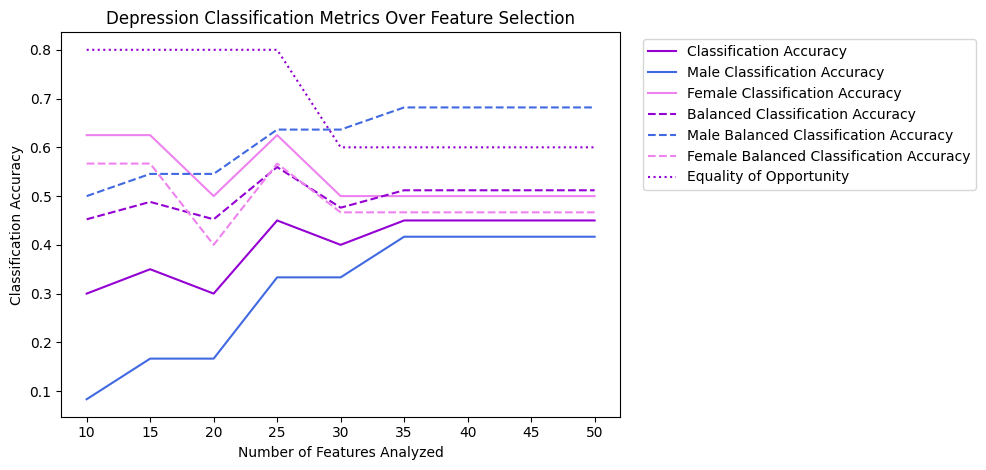

In [52]:
from matplotlib import pyplot as plt
# plot results
fig, ax = plt.subplots(1, 1)
num_feats = range(10, 51, 5)
ax.plot(num_feats, class_acc, label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats, male_class_acc, label = "Male Classification Accuracy", color='royalblue') 
ax.plot(num_feats, female_class_acc, label = "Female Classification Accuracy", color='violet') 
ax.plot(num_feats, bca, label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats, male_bca, label = "Male Balanced Classification Accuracy", color='royalblue', linestyle='dashed') 
ax.plot(num_feats, female_bca, label = "Female Balanced Classification Accuracy", color='violet', linestyle='dashed') 
ax.plot(num_feats, eo, label = "Equality of Opportunity", color='darkviolet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Selection')
ax.set_xlabel('Number of Features Analyzed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

The above plot shows the depression classification accuracy measures over male and female participants as the number of features included in the model increase. With minimal (10) features included in the model training, the Random Forest Classifier performs much better on female participants than on male participants. As more features (with decreasing correlation) increase, the classification accuracy on male participants increases, while the classification accuracy on female participants decreases. As the number of features increase, the equality of opportunity nears 60% and the overall classification and balanced classification accuracy nears 50%.

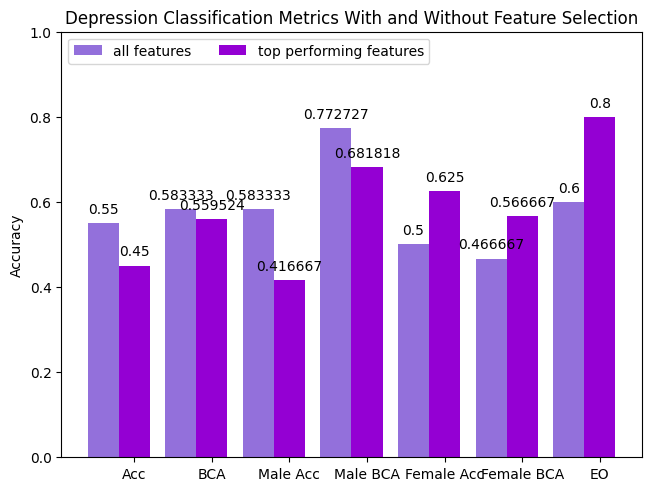

In [56]:
import math
# plot results for depression with and without feature selection
best_ind = bca.index(max(bca))
best_male_ind = male_bca.index(max(male_bca))
best_female_ind = female_bca.index(max(female_bca))
measures = ['Acc', 'BCA', 'Male Acc', 'Male BCA', 'Female Acc', 'Female BCA', 'EO']
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'top performing features': [class_acc[best_ind], bca[best_ind], 
                          male_class_acc[best_male_ind], male_bca[best_male_ind],
                          female_class_acc[best_female_ind], female_bca[best_female_ind], eo[best_ind]]
}
x = np.arange(len(measures))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in vals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color='mediumpurple' if attribute=='all features' else 'darkviolet')
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Depression Classification Metrics With and Without Feature Selection')
ax.set_xticks(x + width, measures)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()


The balanced classification accuracy sees little change from the best performing feature-selection model to the original model. The overall classification accuracy is significantly higher with the original model than with the feature selection model, but these values would likely converge as the number of features included in the analysis increases. 
The original model performs better on classifying the male participants, with a 9% difference in the balanced classificaiton accuracy. However, the feature-selection model performs better on classifying female participants, with a 10% increase in the balanced classification accuracy. Furthermore, the Equality of Opportunity score increases 20% with the feature-selection model. 